In [122]:
# Import necessary libraries and packages
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import warnings
from math import exp
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.python.keras.metrics import Metric

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
# Preferred settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)


2022-04-10 18:07:13.945250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-10 18:07:13.945326: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Import CO2 emissions data - OWID
data = pd.read_csv('../Data/carbon-emissions/owid-co2-data.csv')

#Observe data shape and head
print(data.shape)

(25204, 58)


In [3]:
data.describe()

,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
count,25204.000000,23949.000000,3976.000000,24931.000000,23585.000000,3976.000000,23307.000000,3976.000000,23949.000000,2.394900e+04,23949.000000,15389.000000,3761.000000,9141.000000,17188.000000,12248.000000,4382.000000,8845.000000,20539.000000,1999.000000,12218.000000,16860.000000,4381.000000,8835.000000,20181.000000,1999.000000,3976.000000,12248.000000,17188.00000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,5208.000000,5155.000000,5211.000000,5157.000000,5211.000000,5157.000000,2.287800e+04,1.353800e+04,8690.000000,8681.000000,6803.000000
mean,1953.225797,267.861942,916.755170,21.098600,5.146889,-2.415624,4.170811,6.567721,4.983979,1.035710e+04,5.126531,0.421795,0.370038,0.238931,175.358171,12.888607,15.000326,108.750774,106.254381,15.753891,0.113037,1.551520,0.875319,1.413336,2.635498,0.080168,22.961190,4.419452,6.98983,5.861506,5.405564,2.993497,14.295183,307.761167,8791.767180,425.698588,2587.096729,3296.584230,293.588436,4.462228,7.211834,5.621670,5.242400,3.001620,13.403622,441.481429,8.099506,82.253370,2.046923,29.308135,0.606690,7.072322e+07,2.877088e+11,1569.083895,25568.487454,1.850291
std,53.791369,1521.680894,3373.348275,702.565991,55.259760,182.444942,14.912201,6.927957,17.704994,6.120603e+04,18.480079,0.483864,0.265374,0.233550,786.106838,77.258563,40.471977,441.064563,602.683622,39.385589,0.148907,2.552112,5.477923,3.654290,15.129275,0.055779,45.055039,15.950613,20.76197,14.874259,18.408881,12.018682,28.570911,1706.159528,39131.720328,1320.911296,12347.690600,21645.263301,777.706862,15.685264,21.636504,15.021334,18.926934,12.134102,27.019447,3089.039496,9.387477,566.702756,3.534126,199.291118,0.844671,3.795858e+08,2.180094e+12,9066.102799,33319.956208,1.575161
min,1750.000000,0.000000,0.197000,-99.640000,-1895.244000,-1657.998000,0.000000,0.055000,0.000000,0.000000e+00,0.000000,0.000000,0.006000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-96.760000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-85.620000,-50.487000,0.000000,0.000000,0.000000,0.000000,1.490000e+03,5.543200e+07,0.000000,0.000000,0.050000
25%,1925.000000,0.528000,10.319750,-0.450000,-0.011000,-0.892500,0.253000,1.240250,0.010000,6.992000e+00,0.000000,0.140000,0.216000,0.178000,0.322000,0.129000,0.253250,0.385000,0.311000,0.747500,0.020000,0.054000,0.021000,0.031000,0.121000,0.036000,-1.757500,0.050000,0.01000,0.090000,0.030000,0.010000,0.300000,1.613000,5.516250,4.071250,3.239000,3.921000,7.709000,0.040000,0.000000,0.060000,0.010000,0.010000,0.190000,8.162500,2.514000,2.150000,0.715000,0.535000,0.228000,1.291899e+06,9.828867e+09,6.997000,3270.369000,0.856000
50%,1967.00

# Data Cleaning and Preprocessing


We focused on post-1950 data for our comparative analysis and global EDA since some countries are missing significant data before that time. Major carbon emitting countries' emission activites intensified post 1950 period, especially India. For our modelling process, however, focusing on India, the data form 1878 is continous, so we include all data for India from 1900. First, We'll be predicting the CO2 emissions for India

In [4]:
#load data
df_India = data
df_India.isnull().sum()

iso_code                                3256
country                                    0
year                                       0
co2                                     1255
consumption_co2                        21228
co2_growth_prct                          273
co2_growth_abs                          1619
trade_co2                              21228
co2_per_capita                          1897
consumption_co2_per_capita             21228
share_global_co2                        1255
cumulative_co2                          1255
share_global_cumulative_co2             1255
co2_per_gdp                             9815
consumption_co2_per_gdp                21443
co2_per_unit_energy                    16063
coal_co2                                8016
cement_co2                             12956
flaring_co2                            20822
gas_co2                                16359
oil_co2                                 4665
other_industry_co2                     23205
cement_co2

In [5]:
#only include India co2 per capita data post-1900
df_India = df_India[df_India['year'] >= 1900]
df_India = df_India[df_India['country'] == 'India']
df_India = df_India[['year', 'co2_per_capita']]

#observe shape of reformatted df
print(df_India.shape)

(121, 2)


In [6]:
#Convert year to index
df_India.set_index('year', inplace=True)

#Convert year to DateTime object
df_India.index = pd.to_datetime(df_India.index, format='%Y')

In [7]:
#observe updated df
#df_India.head()
df_India.sample(5)

,co2_per_capita
year,
1975-01-01,0.376
1913-01-01,0.101
2014-01-01,1.687
1997-01-01,0.859
1999-01-01,0.917


# Exploratory Data Analysis

**Reviewing plots of the density of observations can provide further insight into the structure of the data**

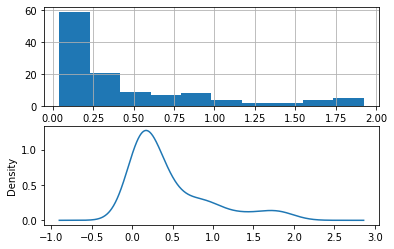

In [8]:
#observe density
pyplot.figure(1)
pyplot.subplot(211)
df_India.co2_per_capita.hist()
pyplot.subplot(212)
df_India.co2_per_capita.plot(kind='kde')
pyplot.show()

From the above graphs we can observe, 
- The distribution is not perfectly Gausian (normal distribution)
- The distribution in non-linearly left shifted 
- Transformations might be useful prior to modelling

**Reviewing Box plot of emissions over decades provides insight into the trend and seasonality of the data**

<AxesSubplot:xlabel='year', ylabel='co2_per_capita'>

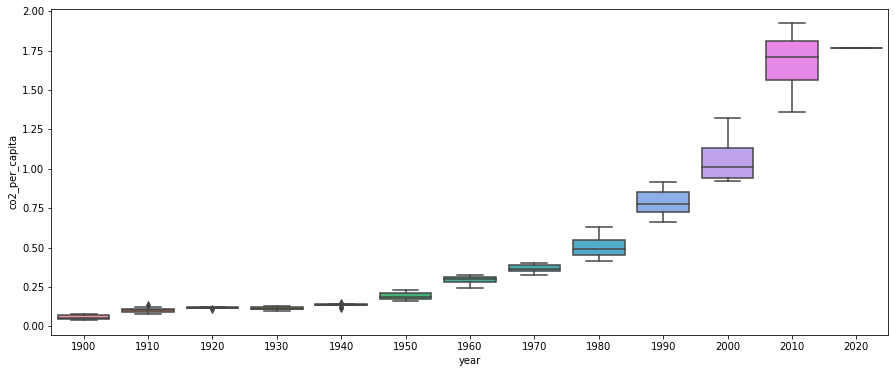

In [9]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df_India.co2_per_capita.index.year // 10 * 10, df_India.co2_per_capita, ax=ax)

From the above plot we can observe,
- Median values across decade confirms an irregular upward trend
- Exponential Increase in emissions

**Distribution and Normality Test**

Kurtosis of normal distribution 1.3473828867240432
Skewness of normal distribution 1.5203681429926796


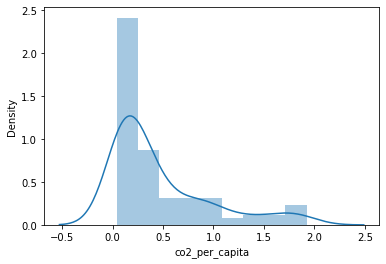

In [10]:
#observe distribution and normality
sns.distplot(df_India.co2_per_capita);
stats.normaltest(df_India.co2_per_capita)
print('Kurtosis of normal distribution {}'.format(stats.kurtosis(df_India.co2_per_capita)))
print( 'Skewness of normal distribution {}'.format(stats.skew(df_India.co2_per_capita)))

> - Kurtosis describes heaviness of the tails of distribution
    - Normal Distribution has a kurtosis of 0 (mesokurtic). A Positive value (as observed)  shows us that the data has heavy-tails. A neagtive value mean that data has ligh tails


> - Skewness 
    - if < -1 / > 1 -distribution is highly skewed. (as observed)
    - if -1 < skew < - 0.5 / 0.5 < skew < 1 - distribution is moderately skewed. 
    - if -0.5 < skew < 0.5 - distribution is approximately similar

Lets observe the per capita emissions distribution before hand

,count,mean,std,min,25%,50%,75%,max
co2_per_capita,121.0,0.461694,0.493446,0.041,0.12,0.247,0.662,1.922


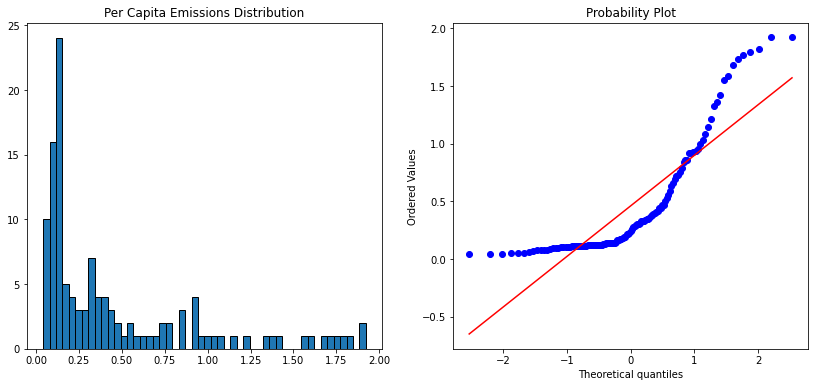

In [11]:
#observe distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df_India.co2_per_capita.hist(bins=50,edgecolor='black', grid=False)
plt.title('Per Capita Emissions Distribution')

plt.subplot(1,2,2)
stats.probplot(df_India.co2_per_capita, plot=plt);
#print("Skewness: %f" % df['Consumption'].skew())
#print("Kurtosis: %f" % df['Consumption'].kurt())
df_India.describe().transpose()

Normal probability plot shows that data set has irregular distribution, with trends

**Before starting to analyse the stationarity of data, lets need to understand the trend, seasonality and bias of our data by Decomposing** 

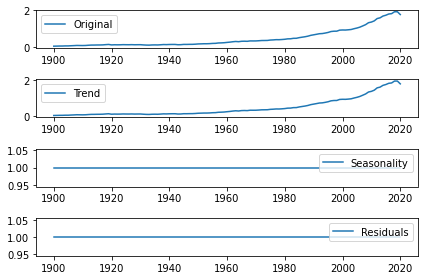

In [12]:
#observe trend and seasonality
from pylab import rcParams
decomposition = sm.tsa.seasonal_decompose(df_India.co2_per_capita, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_India.co2_per_capita, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

With Observations from decomposing we observe,
- No seasonal characteristics of Data
- Constant residual
- Exponential Increaseing trend

### Naive Model Using Holt-Winter's Method

We start with Holt's method, which does not account for seasonality

In [13]:
# Train-test split
df_es = df_India
x = df_es.index
y = df_es.co2_per_capita

train = df_es.loc[:'1991-01-01']
test = df_es.loc['1991-01-01':]

In [14]:
df_es.shape

(121, 1)

**Holt's Method - Double Exponential Smoothening**

using trend as additive

In [15]:
#apply double exponential smoothening
model_des = ExponentialSmoothing(train.co2_per_capita,trend = 'add')
model_des_fit = model_des.fit()
train['DES_model'] = model_des_fit.fittedvalues.shift(-1)

<AxesSubplot:xlabel='year'>

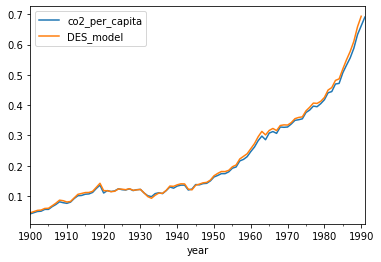

In [16]:
# observe the DES model against the original data
train[['co2_per_capita','DES_model']].plot(legend = True)

Lets observe a closer look to analyse the results better

<AxesSubplot:xlabel='year'>

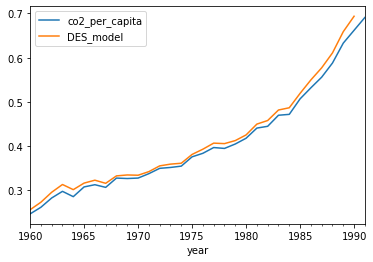

In [17]:
#observe a closer look
train[['co2_per_capita','DES_model']]['1960-01-01':'2020-01-01'].plot(legend = True)

From above, we observe Double Exponential Smoothening results looks reasonable well

**Holt-Winter's Method - Triple Exponential Smoothening**

Using trend and seasonality as multiplicative. Setting the number of seasonal_periods as 12 (yearly)

In [18]:
model_tes = ExponentialSmoothing(train.co2_per_capita,trend = 'add', seasonal = 'add', seasonal_periods=12)
model_tes_fit = model_tes.fit()
train['TES_model'] = model_tes_fit.fittedvalues.shift(-1)

<AxesSubplot:xlabel='year'>

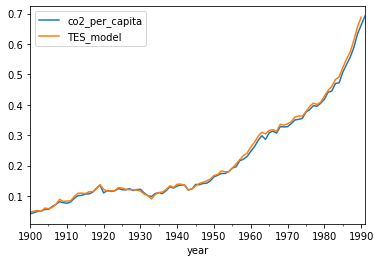

In [19]:
# observe the DES model against the original data
train[['co2_per_capita','TES_model']].plot(legend = True)

Lets observe Results of Double and Triple Exponential Smoothening

<AxesSubplot:xlabel='year'>

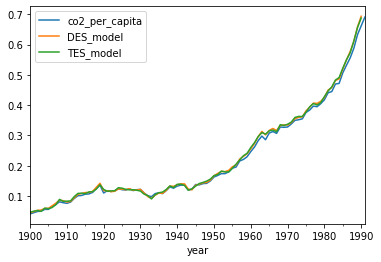

In [20]:
# observe the DES model against the original data
train[['co2_per_capita','DES_model','TES_model']].plot(legend = True)

Lets observe a closer look to analyse the results better

<AxesSubplot:xlabel='year'>

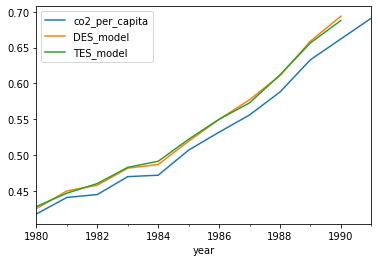

In [21]:
#observe a closer loo
train[['co2_per_capita','DES_model','TES_model']]['1980-01-01':'2000-01-01'].plot(legend = True)

From above, we observe both Double Exponential Smoothening, Triple Exponential Smoothening results looks similar and  reasonably very well with original data

**Double and Triple Exponential Models : Forecasts**

Lets forecast on test set of data

In [22]:
#forecast on test set
test_des = model_des_fit.forecast(30)
test_tes = model_tes_fit.forecast(30)

<AxesSubplot:xlabel='year'>

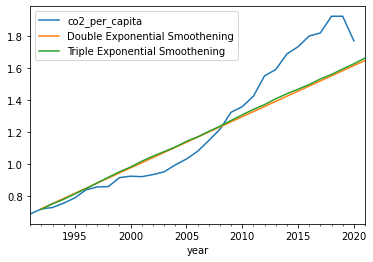

In [23]:
# Plotting Test predictions against the test set
test['co2_per_capita'].plot(legend = True)
test_des.plot(legend = True, label = "Double Exponential Smoothening")
test_tes.plot(legend = True, label = "Triple Exponential Smoothening")

In [24]:
#evaluate mse
des_mse = mean_squared_error(test.co2_per_capita, test_des)
tes_mse = mean_squared_error(test.co2_per_capita, test_tes)

print(" RMSE for the Double Exponential Smoothening Model : ", np.sqrt(des_mse))
print(" RMSE for the Triple Exponential Smoothening Model : ", np.sqrt(tes_mse))

 RMSE for the Double Exponential Smoothening Model :  0.15276656079741188
 RMSE for the Triple Exponential Smoothening Model :  0.14843679228340276


From above results, we can observe RMSE of **Holt-Winter's - Triple Exponential Smoothening** is less and TES performs well for forecasting data post 1991

In [25]:
test_tes_40 = model_tes_fit.forecast(40)
test_tes_40[:40]

1992-01-01    0.718947
1993-01-01    0.753862
1994-01-01    0.782034
1995-01-01    0.815936
1996-01-01    0.848346
1997-01-01    0.884063
1998-01-01    0.919198
1999-01-01    0.953036
2000-01-01    0.983062
2001-01-01    1.018909
2002-01-01    1.050657
2003-01-01    1.078842
2004-01-01    1.107715
2005-01-01    1.142630
2006-01-01    1.170803
2007-01-01    1.204704
2008-01-01    1.237114
2009-01-01    1.272832
2010-01-01    1.307966
2011-01-01    1.341804
2012-01-01    1.371830
2013-01-01    1.407677
2014-01-01    1.439425
2015-01-01    1.467610
2016-01-01    1.496483
2017-01-01    1.531398
2018-01-01    1.559571
2019-01-01    1.593472
2020-01-01    1.625883
2021-01-01    1.661600
2022-01-01    1.696735
2023-01-01    1.730572
2024-01-01    1.760598
2025-01-01    1.796445
2026-01-01    1.828193
2027-01-01    1.856378
2028-01-01    1.885251
2029-01-01    1.920167
2030-01-01    1.948339
2031-01-01    1.982240
Freq: AS-JAN, dtype: float64

<AxesSubplot:xlabel='year'>

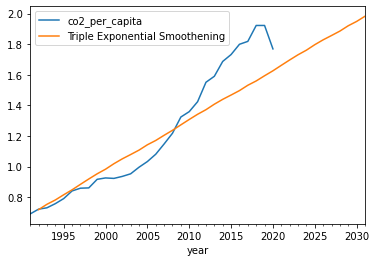

In [26]:
# Plotting Test predictions against the test set
test['co2_per_capita'].plot(legend = True)
test_tes_40.plot(legend = True, label = "Triple Exponential Smoothening")

We've achieved a exponentially smoothened forecast, lets compare this with ARIMA models.

Naive Holt's and Holt-Winter's exponential smoothening works with non-stationary data, But for ARIMA models we need to check stationarity to know the order of differnecing required inorder to obtain better results

Lets check stationarity and process the data

**Check for Stationarity**
- Any time series data is said to be stationary if its statistical properties such as mean, variance remains constant over time

lets observe the properties 

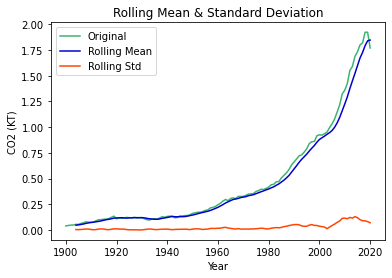

In [27]:
#Visualize India's CO2 emissions since 1900,
#including 5-year rolling mean and rolling standard deviation

roll_mean = df_India.rolling(window=5, center=False).mean()
roll_std = df_India.rolling(window=5, center=False).std()

plt.plot(df_India, color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('CO2 (KT)')
plt.show(block=False)

Working with time series data we need to understand the nature of data, that is the trends and stationarity.

Stationarity can be checked by 
- performing an **Augmented Dickey-Fuller (ADF) test** 
- **ACF and PACF Plots**
- Plotting Rolling Statistics


Lets observe the stationarity performing an **Augmented Dickey-Fuller (ADF) test**

in ADF test, null hypothesis - there is a unit root in an AR model, which implies that the data series is not stationary

> - p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
> - p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary

#### Dickey-Fuller Test

In [28]:
#perform Dickey-Fuller test
test_result = adfuller(df_India['co2_per_capita'][1:-1])
df_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_result

ADF Statistic                                                        4.772611
p-value                                                                   1.0
#Lags Used                                                                 12
No. of Observations Used                                                  106
Critical Values             {'1%': -3.4936021509366793, '5%': -2.889217423...
dtype: object

With p-value of 1.0 ( >0.05), we cannot reject that null hypothesis that this is non-stationary.

we also can see that our ADF statistic value (6.76) is greater than tha value -3.49 at 1%. This suggests that we cannot reject the null hypothesis with a significance of less than 1%, i.e. a low probability that the result is a statistical fluke. The process has unit root and in turn the timer series is un-stationary or does have time-dependent structure

As we observe the data is non-stationary, this cannot be fit for autocorrelation analysis as ACF and PACF assumes data stationary. Lets remedy this below before fitting our model.
    

## Addressing Trends and Stationarity

lets observe stationarity plotting rolling statistics and address the stationarity

### Log Transformation

In log transformation we apply logarithmic function to a point, and model the time series with the new log-transformed data. 

we can address lack of variance and covariance by log transformation

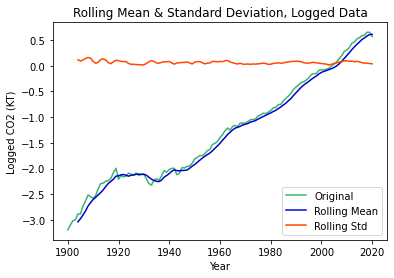

In [29]:
#apply log transformation
#Create new dataframe that contains the logged values of the original one
log_India = log(df_India)

#Visualize Logged data, including 5-year rolling mean and standard deviation
roll_mean_log = log_India.rolling(window=5, center=False).mean()
roll_std_log = log_India.rolling(window=5, center=False).std()

plt.plot(log_India, color='mediumseagreen', label='Original')
plt.plot(roll_mean_log, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_log, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Logged Data')
plt.xlabel('Year')
plt.ylabel('Logged CO2 (KT)')
plt.show(block=False)

Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log transformed data**

In [30]:
#perform Dickey-Fuller test for log tranformed data
test_result = adfuller(log_India['co2_per_capita'][1:-1])
df_log_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_log_result

ADF Statistic                                                        1.182281
p-value                                                              0.995861
#Lags Used                                                                 11
No. of Observations Used                                                  107
Critical Values             {'1%': -3.492995948509562, '5%': -2.8889546480...
dtype: object

With p-value of 0.99 ( >0.05), we still cannot reject that null hypothesis that this data is non-stationary. 

Log transformation did not help achieve stationarity. So lets try another way to achieve true stationarity by subtracting rolling mean of log tranformation



#### Subtracting the Rolling Mean of the Log Transformation

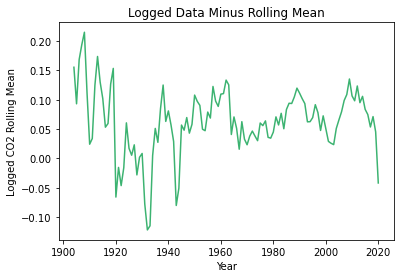

In [31]:
#subtracting rolling mean of log transformation
log_minus_rollmean = log_India - roll_mean_log

#drop null values
log_minus_rollmean.dropna(axis=0, inplace=True)

#observe data
plt.plot(log_minus_rollmean, color='mediumseagreen')
plt.title('Logged Data Minus Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Logged CO2 Rolling Mean')
plt.show(block=False)


Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log-minus-roll-mean data**

In [32]:
#perform Dickey-Fuller test for log-minus-rollmean data
test_result = adfuller(log_minus_rollmean['co2_per_capita'][1:-1])
df_sublog_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_sublog_result

ADF Statistic                                                       -3.855635
p-value                                                              0.002387
#Lags Used                                                                 13
No. of Observations Used                                                  101
Critical Values             {'1%': -3.4968181663902103, '5%': -2.890610751...
dtype: object

With p-value of 0.002 ( <0.05), we reject that null hypothesis. This data does not unit root and is stationary.

we also can see that our ADF statistic value (-3.85) is less than the value -3.49 at 1%. This suggests that we can reject the null hypothesis with a significance of less than 1%.

This data looks much more stationary based on its plot and its Dickey-Fuller test alos yielded similar observation as observed above with a very low p-value, indicating that we can confidently reject the null hypothesis that the data is non-stationary.



> Even though this data is stationary and would likely work well in a time series model, the results of this model would not be interpretable in the context of our business problem.  

> For our predictions to be useful, we need them to be in terms of CO2 emissions in K Tonnes. Altering our data to this degree would make them uninterpretable for this purpose, and so we will not pursue a model on this data

### Differencing

differencing is a very powerful technique to address non-stationary time-series data. Differencing works very well with practical time series.

The original data where the ADF test arrived at p-value = 1 suggests no difference between the groupds other than due to chance


Now that we have observed log tranformed, we will now observe differnece of our original data until we achieve stationarity so we can model on both datasets

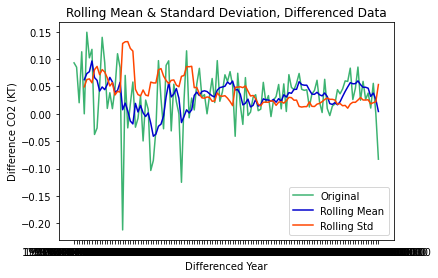

In [33]:
#create dataframe for differencing
log_diff = log_India.diff().dropna().rename(index=str, columns={"co2_per_capita":"Differenced Observations"})

#Visualize differenced data, inclusing 5-year rolling mean and standard deviation
roll_mean_diff = log_diff.rolling(window=5, center=False).mean()
roll_std_diff = log_diff.rolling(window=5, center=False).std()

plt.plot(log_diff, color='mediumseagreen', label='Original')
plt.plot(roll_mean_diff, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_diff, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Differenced Data')
plt.xlabel('Differenced Year')
plt.ylabel('Difference CO2 (KT)')
plt.show(block=False)


Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log-minus-roll-mean data**

In [34]:
#perform Dickey-Fuller test for log-minus-rollmean data
diff_result = adfuller(log_diff['Differenced Observations'][1:-1])
df_diff_result = pd.Series(diff_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_diff_result

ADF Statistic                                                       -3.172023
p-value                                                              0.021662
#Lags Used                                                                 13
No. of Observations Used                                                  104
Critical Values             {'1%': -3.4948504603223145, '5%': -2.889758398...
dtype: object

With p-value of 0.021 ( <0.05), we reject that null hypothesis. This data does not unit root and is stationary.

The ADF statistic value (-10.80) is very much less than the value -3.48 at 1%. This suggests that we can comfortably reject the null hypothesis with a significance of less than 1%.

Based on real p-value of 0.02, we have achieved stationarity by 1st order differencing. We will keep this in count as we test d values in our ARIMA models


**Lets Observe both trend and stationality of the logged data**

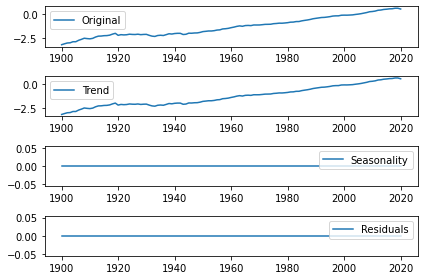

In [35]:
decomposition = seasonal_decompose(log_India)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(log_India, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Modelling


We will create time series models on both our logged data and original data to see which yields better results.

### Logged Data

**ACF for Logged Data**

ACF gives correlation between time series with a lagged version of itself. The autocorrelation function starts a lag 0, which is correlation of the time series with itself and therefore results in correlation of 1.

Auto correlation graphs are used to determine the order of MA model (p values) to be used in the ARIMA Model

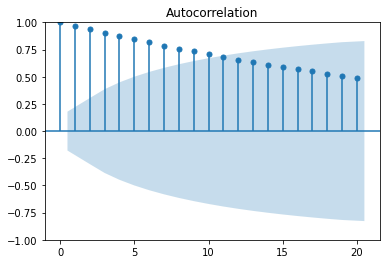

In [36]:
# observe ACF for logged data
plot_acf(log_India[:-1], alpha=.05, lags=20);

**PACF for Logged Data**

PACF gives additional correaltion explained by each successive lagged term. A partial autocorrelation at lag k is the autocorrelation between 𝑋𝑡  and 𝑋𝑡−𝑘. 

Partial Autocorrelation are used to determine the order of AR model - q values to be used in the ARIMA Model

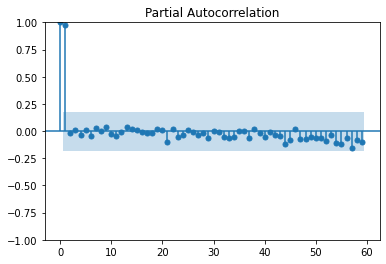

In [37]:
# PACF for logged data
plot_pacf(log_India[:-1], alpha=.05, lags=59);

From the above ACF and PACF for our logged data, we can observe

> - A series that has a dampened geometric decay of Autocorrelation and Significant at each lag  𝑝  / Cuts off after lag  𝑝 - AR  𝑝   model

> -  Our data displayes an AR signature since ACF diminishes gradually and the PACF uctts off sharply at lag 2, showing string correlation. This tells us we would expect to have atleast one AR parameter.

> -  When instantiating an ARIMA model, we expect a relatively large number of MA terms due to large number of significant ACF points and relatively smaller AR terms due to small number of significant PACF points.

### ARIMA Model

**ARIMA Model for Logged Data**

we triend many differenct p,d, and q parameters for an ARIMA model on our logged data. The below parameters yielded best results

In [38]:
#Instantiate model
model_log = ARIMA(log_India[:-1], order=(2,0,2))

#Fit Model
results = model_log.fit()

#observe summary statistics
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 170.324
Date:                Sun, 10 Apr 2022   AIC                           -328.647
Time:                        17:40:10   BIC                           -311.922
Sample:                    01-01-1900   HQIC                          -321.855
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2083      2.118     -0.570      0.568      -5.360       2.944
ar.L1          0.0332      0.098      0.340      0.734      -0.159       0.225
ar.L2          0.9653      0.100      9.695      0.0

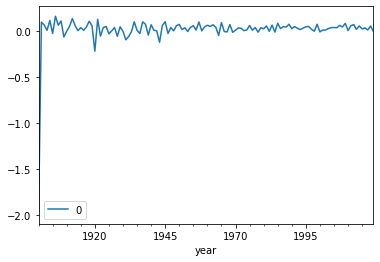

In [39]:
#observe residuals/errors
residuals = DataFrame(results.resid)
residuals.plot()
plt.show()


In [40]:
#observe distributions
residuals.describe()

,0
count,120.000000
mean,0.008962
std,0.190513
min,-1.985854
25%,-0.001710
50%,0.031765
75%,0.054662
max,0.156651


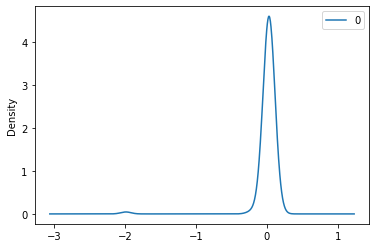

In [41]:
#observe linearity
residuals.plot(kind='kde')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

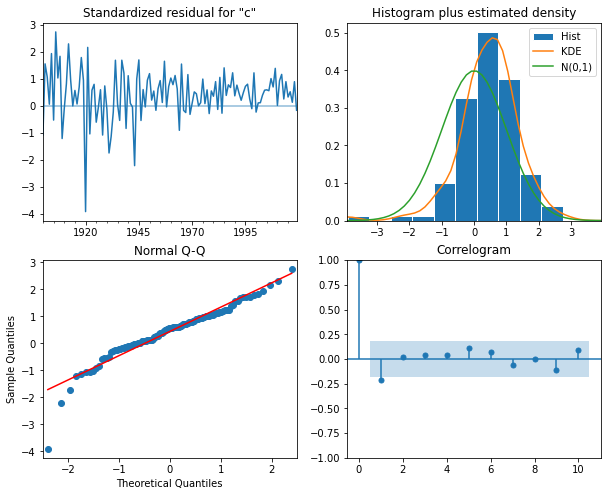

In [42]:
#observe diagnostics
results.plot_diagnostics(figsize=(10,8))
plt.show

### Original Data

We will now observe an ARIMA model on our original, non-logged data. We saw this data needs to be differenced in order to achieve stationarity, so we expect to have a d value of at least 1 for out best model

**ACF and PACF for Original Data**

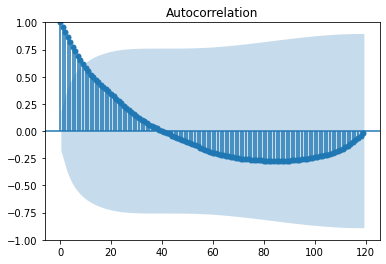

In [43]:
# ACF for original data
plot_acf(df_India[:-1], alpha=.05, lags=119);

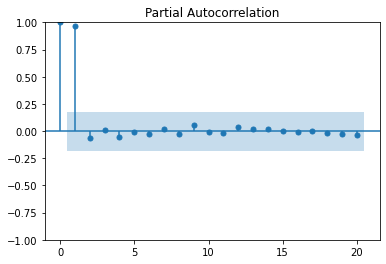

In [44]:
# PACF for original data
plot_pacf(df_India[:-1], alpha=.05, lags=20);

From the above ACF and PACF for our original data, we can observe

> - A series that has a dampened geometric decay of Autocorrelation and Significant at each lag  𝑝  / Cuts off after lag  𝑝 - AR  𝑝   model

> - Our data displayes an AR signature since ACF diminishes gradually and the PACF uctts off sharply at lag 2, showing string correlation. This tells us we would expect to have atleast one AR parameter.

> -  When instantiating an ARIMA model, we expect a relatively large number of MA terms due to large number of significant ACF points and relatively smaller AR terms due to small number of significant PACF points. 

**ARIMA Model for Original Data**

we tried many different p,d, and q parameters for an ARIMA model on our original data. The set of parameters yielded the best resutls, which we will comapre in mode details later.

In [45]:
#building the auto-arima model to compare our observed ordered
from pmdarima.arima import auto_arima
model = auto_arima(df_India, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(df_India)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-543.778, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-512.130, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-523.722, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-531.675, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-531.841, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-534.944, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-539.052, Time=0.13 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-538.424, Time=0.17 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-529.778, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-533.195, Time=0.13 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-542.912, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-540.229, Time=0.19 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 1.328 seconds


ARIMA(order=(2, 2, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [46]:
# Instantiate model
mod212 = ARIMA(df_India[:-1], order=(2,1,2))

# Fit model
mod212_fit = mod212.fit()

# Observe summary statistics
print(mod212_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 321.558
Date:                Sun, 10 Apr 2022   AIC                           -633.116
Time:                        17:40:13   BIC                           -619.220
Sample:                    01-01-1900   HQIC                          -627.473
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0298      0.144      7.149      0.000       0.747       1.312
ar.L2         -0.0602      0.149     -0.405      0.686      -0.352       0.231
ma.L1         -1.0752      0.119     -9.009      0.0

In [47]:
# Instantiate model
mod222 = ARIMA(df_India[:-1], order=(2,2,2))

# Fit model
mod222_fit = mod222.fit()

# Observe summary statistics
print(mod222_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 316.352
Date:                Sun, 10 Apr 2022   AIC                           -622.704
Time:                        17:40:13   BIC                           -608.851
Sample:                    01-01-1900   HQIC                          -617.079
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9212      1.269     -0.726      0.468      -3.408       1.565
ar.L2         -0.2608      0.601     -0.434      0.664      -1.438       0.917
ma.L1         -0.1010      1.249     -0.081      0.9

In [48]:
# Instantiate model
mod212 = ARIMA(df_India[:-1], order=(2,1,2))

# Fit model
mod212_fit = mod222.fit()

# Observe summary statistics
print(mod212_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 316.352
Date:                Sun, 10 Apr 2022   AIC                           -622.704
Time:                        17:40:13   BIC                           -608.851
Sample:                    01-01-1900   HQIC                          -617.079
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9212      1.269     -0.726      0.468      -3.408       1.565
ar.L2         -0.2608      0.601     -0.434      0.664      -1.438       0.917
ma.L1         -0.1010      1.249     -0.081      0.9

In [49]:
# Instantiate model
mod222 = ARIMA(df_India[:-1], order=(2,1,3))

# Fit model
mod222_fit = mod222.fit()

# Observe summary statistics
print(mod222_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 321.772
Date:                Sun, 10 Apr 2022   AIC                           -631.544
Time:                        17:40:13   BIC                           -614.870
Sample:                    01-01-1900   HQIC                          -624.773
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1164      0.907      0.128      0.898      -1.662       1.895
ar.L2          0.8137      0.871      0.935      0.350      -0.893       2.520
ma.L1         -0.2006      0.939     -0.214      0.8

## Determining the Best Model

To determina the best model of the above, we will fit them each to out train-test-split data and evaluate RMSE and AIC scores

We choose to split our train and test sets in 1991, which is 75%/25% split. We made this choice because India's emissions found a sudden steep increase in 1990's (due to LPG of economy and high industrialization). A split of this range may yield a model that could predict such sudden increasing patterns.

Interestingly, The first ever convention on climate change UNFCCC was drafted around this time, urging the countries to focus on reducing the emissions of GHG gases

### Re-Fit Models to Train-Test Split Data 

**Logged Data**

In [50]:
# Train-test split
x = log_India.index
y=log_India['co2_per_capita']

train = log_India.loc[:'1991-01-01']
test = log_India.loc['1991-01-01':]

x_train, x_test = train.index, test.index
y_train, y_test = train['co2_per_capita'], test['co2_per_capita']

In [51]:
#ARIMA Model
#Instantiate and fit model to train data
model_log = ARIMA(y_train[2:], order=(2,0,2))
model_log_fit = model_log.fit()

#prediction
pred_log = model_log_fit.predict(start='1996-01-01', end='2020-01-01', dynamic=False)

**Original Data**

In [52]:
# Train-test split
x = df_India.index
y = df_India['co2_per_capita']

train = df_India.loc[:'1991-01-01']
test = df_India.loc['1991-01-01':]

x_train, x_test = train.index, test.index
y_train, y_test = train['co2_per_capita'], test['co2_per_capita']

In [53]:
# 212  data
# Instantiate and fit model to train data
model212 = ARIMA(y_train[2:], order=(2,1,2)) #p,d,q
model212_fit = model212.fit()

#Prediction
pred212 = model212_fit.predict(start='1990-01-01', end='2020-01-01', dynamic=False)

In [54]:
# 213  data
# Instantiate and fit model to train data
model213 = ARIMA(y_train[2:], order=(2,1,3))
model213_fit = model213.fit()

#Prediction
pred213 = model213_fit.predict(start='1990-01-01', end='2020-01-01', dynamic=False)

In [55]:
# 222  data
# Instantiate and fit model to train data
model222 = ARIMA(y_train[2:], order=(2,2,2))
model222_fit = model222.fit()

#Prediction
pred222 = model222_fit.predict(start='1990-01-01', end='2020-01-01', dynamic=False)

### Determining Best Model via

> - Root Mean Squared Error (RMSE)
> - Akaike Information Criterian (AIC) Score
> - Mean Absolute Error (MAE)
> - Mean Absolute Percentabe Error (MAPE)


**Root Mean Squared Error**

Gives higher penalty to big deviations

In [56]:
#Create a function to calculate RMSE for non-logged data
def RMSE_reg(pred, y_test):
    return np.sqrt(((pred-y_test)**2).mean())

#Create a function to calculate RMSE for logged data
#Uses inverse log function our logged predictions (e^pred),
#So we can compare directly to the actual values 
def RMSE_log(pred):
    return np.sqrt((((np.e**pred)-y_test)**2).mean())

print('RMSE for ARIMA (2,1,2) model on original data: ', RMSE_reg(pred212, y_test))
print('RMSE for ARIMA (2,1,3) model on original data: ', RMSE_reg(pred213, y_test))
print('RMSE for ARIMA (2,2,2) model on original data: ', RMSE_reg(pred222, y_test))
print('RMSE for ARIMA (2,0,2) model on Logged data: ', RMSE_log(pred_log))


RMSE for ARIMA (2,1,2) model on original data:  0.2606770305746271
RMSE for ARIMA (2,1,3) model on original data:  0.22038227160179624
RMSE for ARIMA (2,2,2) model on original data:  0.1434490184382893
RMSE for ARIMA (2,0,2) model on Logged data:  0.7359845514961364


**AIC**


In [57]:
#Create a function to calculate AIC for our models
def AIC(fit_model):
    return fit_model.aic

print('AIC score for ARIMA (2,1,2) model on original data: ', AIC(model212_fit))
print('AIC score for ARIMA (2,1,3) model on original data: ', AIC(model213_fit))
print('AIC score for ARIMA (2,2,2) model on original data: ', AIC(model222_fit))
print('AIC score for ARIMA (2,0,2) model on logged data: ', AIC(model_log_fit))

AIC score for ARIMA (2,1,2) model on original data:  -566.9033368729132
AIC score for ARIMA (2,1,3) model on original data:  -568.2600313985416
AIC score for ARIMA (2,2,2) model on original data:  -566.2535495531865
AIC score for ARIMA (2,0,2) model on logged data:  -229.6255087460619


**Mean Absolute Error**

Interpretable metric because it has the same unit of measurement as intial series

In [58]:
from sklearn.metrics import mean_absolute_error
#Create a function to calculate AIC for our models
def MAE(pred):
    return mean_absolute_error(df_India['1990-01-01':].co2_per_capita, pred)

print('MAE for ARIMA (2,1,2) model on original data: ', MAE(pred212))
print('MAE for ARIMA (2,1,3) model on original data: ', MAE(pred213))
print('MAE for ARIMA (2,2,2) model on original data: ', MAE(pred222))

MAE for ARIMA (2,1,2) model on original data:  0.16417284398478593
MAE for ARIMA (2,1,3) model on original data:  0.14591924816150123
MAE for ARIMA (2,2,2) model on original data:  0.10809789553146072


**Mean Absolute Percentage Error**
 
measure of prediction accuracy of a forecasting method



In [59]:
#Creare a function to calculate MAPE for our models
def MAPE(pred): 
    return np.mean(np.abs((df_India['1990-01-01':].co2_per_capita - pred) / df_India['1990-01-01':].co2_per_capita)) * 100

print('MAPE for ARIMA (2,1,2) model on original data: ', MAPE(pred212))
print('MAPE for ARIMA (2,1,3) model on original data: ', MAPE(pred213))
print('MAPE for ARIMA (2,2,2) model on original data: ', MAPE(pred222))

MAPE for ARIMA (2,1,2) model on original data:  10.214898715312989
MAPE for ARIMA (2,1,3) model on original data:  9.570358083071822
MAPE for ARIMA (2,2,2) model on original data:  8.052153289602733


Based on the above, we see that our model on our original data is much more predcitive than our models on logged data. We can also observe that 
- ARIMA (2,2,2) yeild Higher AIC score than ARIMA (2,1,3), (2,1,2),
- ARIMA (2,2,2) yeild lower RMSE value than ARIMA (2,1,2), (2,1,3),
- ARIMA (2,2,2) yeild lower MAE value than ARIMA (2,1,2), (2,1,3),
- ARIMA (2,2,2) yield lower MAPE value than ARIMA (2,1,2), (2,1,3)

Lower Values of RMSE, MAE and MAPE values shows that the model fits more accurately compared to the original data.


Based on our observation of RMSE, MAE, MAPE values, ARIMA (2,2,2) is likely to forecast accurately.

We tried new ARIMA parameters on both logged and non-logged, we were unable to further improve our model and our current one remains best fit.

### Analyze Final Model

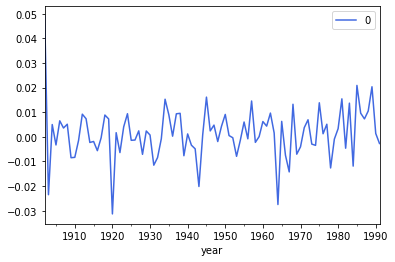

In [60]:
#Visualize resicudals
residuals = DataFrame(model222_fit.resid)
residuals.plot(color='royalblue')
plt.show()

In [61]:
#observe residuals/error distributions
residuals.describe()

,0
count,90.000000
mean,0.001412
std,0.010643
min,-0.031311
25%,-0.003365
50%,0.001223
75%,0.007191
max,0.049000


Based on the above, we observe that our model has minimal error with little bias, with a mean of approximately 0. Next, we observe a density plot of the residual error values, suggesting the errors ar gaussian, but may not be centered on zero

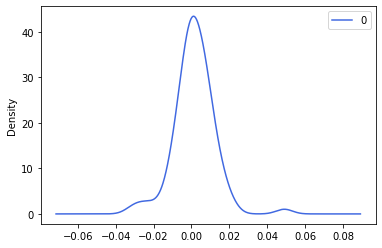

In [62]:
#check for linearlity
residuals = DataFrame(model222_fit.resid)
residuals.plot(kind='kde', color='royalblue')
plt.show()

Based on the above, we observe that our model is nearly linear, with mean of approximately 0. Next we observe the diagnostics to evaluate our model

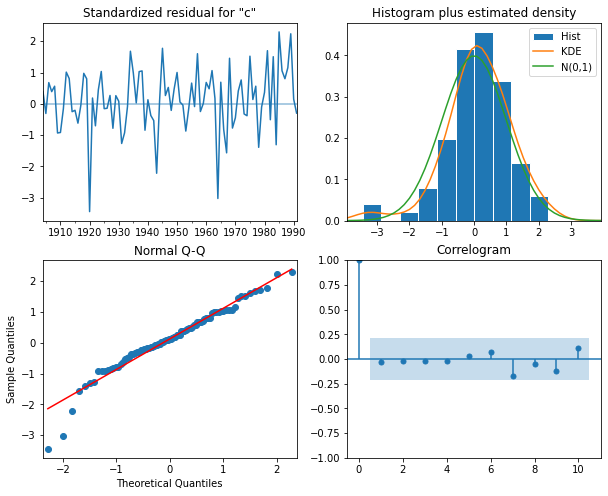

In [63]:
#observe diagonstics
model222_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In the top right plot, thw orangered line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation 1. This is a good indication thath the residuals are normally distributed. The forecast errors deviate a little bit from the straight line, indicating that the normal distribution is not a perfect model for the distribution of forecast errors, but it is not unreasonable.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again,this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e, correlation) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [64]:
#observe predictions
pred_model222 = model222_fit.get_prediction(start='1990-01-01', end='2020-01-01', dynamic=False)
pred_ci = pred_model222.conf_int()
pred_ci.sample(10)

,lower co2_per_capita,upper co2_per_capita
2009-01-01,1.017742,1.573732
2011-01-01,1.041185,1.684252
1998-01-01,0.845736,1.008949
2018-01-01,1.107482,2.086826
1990-01-01,0.642805,0.678464
2005-01-01,0.964194,1.359354
1991-01-01,0.675871,0.711530
1995-01-01,0.782880,0.870790
2019-01-01,1.115086,2.146204
2000-01-01,0.883213,1.105427


we observe the real and forecasted values of the co2 emissions time series to assess how well the model fits.

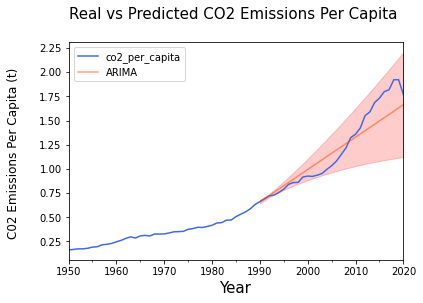

In [65]:
#observe real vs forecasted emissions values

#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue', legend=True)

#plot predicted values
pred_model222.predicted_mean.plot(ax=ax, label='ARIMA', color='orangered', alpha=0.5, legend=True)

#add fill between lines, set axes labels and title
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1],
               color='r', alpha=0.2)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita (t) \n', size=12)
ax.set_title('Real vs Predicted CO2 Emissions Per Capita \n', size=15)

plt.legend()
plt.show()


Above we observe the forecast of per capita co2 emissions based on our fit model. 


The goal of developing the model is to get a good quality predictive power using dynamic forecast. That is, we use information from the timeseries up to a certain point, and after that point, forecasts are generated using values from historical time points 

In [66]:
#get dynamic predictions
pred_dynamic = model222_fit.get_prediction(start='1990-01-01', end='2020-01-01', dynamic=True, full_results=True)
#get confidence Intervals
pred_dynamic_ci = pred_dynamic.conf_int()


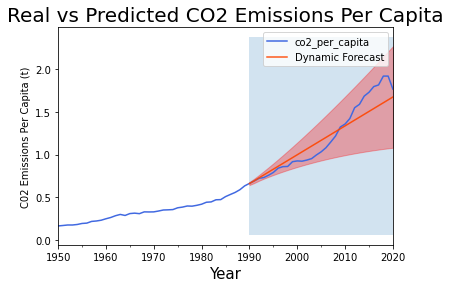

In [67]:
#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:, 0],
               pred_dynamic_ci.iloc[:, 1],
               color='r', alpha=0.3)

ax.fill_betweenx(ax.get_ylim(),
                '1990-01-01',
                df_India.index[-1],
                alpha=0.2,
                zorder= -1)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita (t)', size=10)
ax.set_title('Real vs Predicted CO2 Emissions Per Capita', size=20)

plt.legend()
plt.show()


### Forecast Future CO2 emissions

**CO2 emissions Forecast for next 10 years by 2030**

In [68]:
#get forecast of 10 years stpes ahead in future
forecast2030 = model222_fit.get_forecast(steps=40)
#get confidence Intervals
forecast2030_ci = forecast2030.conf_int()
forecast2030_ci.tail(10)

,lower co2_per_capita,upper co2_per_capita
2022-01-01,1.135275,2.326959
2023-01-01,1.141154,2.388061
2024-01-01,1.146620,2.449577
2025-01-01,1.151677,2.511502
2026-01-01,1.156331,2.573829
2027-01-01,1.160589,2.636552
2028-01-01,1.164455,2.699668
2029-01-01,1.167934,2.763170
2030-01-01,1.171033,2.827053
2031-01-01,1.173754,2.891313


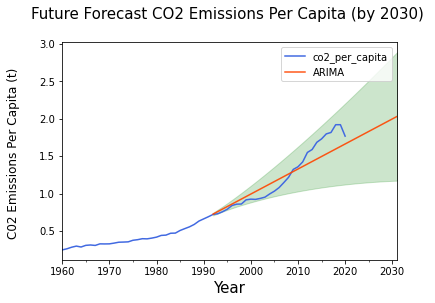

In [69]:
#plot observed values
ax = df_India['1960-01-01':].plot(label='observed', color='royalblue', legend=True)

#plot predicted values
forecast2030.predicted_mean.plot(ax=ax, label='ARIMA', color='orangered', alpha=0.9, legend=True)

#add fill between lines, set axes labels and title
ax.fill_between(forecast2030_ci.index,
               forecast2030_ci.iloc[:, 0],
               forecast2030_ci.iloc[:, 1],
               color='g', alpha=0.2)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita (t) \n', size=12)
ax.set_title('Future Forecast CO2 Emissions Per Capita (by 2030) \n', size=15)

plt.legend()
plt.show()

**CO2 emissions Forecast for next 20 years (by 2045)**

In [70]:
#get forecast of 10 years stpes ahead in future
forecast2045= model222_fit.get_forecast(steps=55)
#get confidence Intervals
forecast2045_ci = forecast2045.conf_int()
forecast2045_ci.sample(10)

,lower co2_per_capita,upper co2_per_capita
2043-01-01,1.178539,3.690306
2012-01-01,1.052123,1.740296
2011-01-01,1.041185,1.684253
2013-01-01,1.062554,1.796846
1998-01-01,0.845736,1.008949
2026-01-01,1.156331,2.573829
2037-01-01,1.182415,3.284541
2022-01-01,1.135275,2.326959
2030-01-01,1.171033,2.827053
2009-01-01,1.017742,1.573733


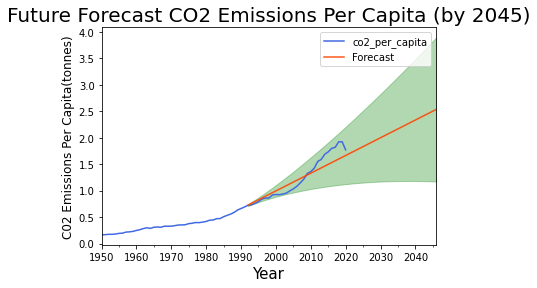

In [71]:
#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
forecast2045.predicted_mean.plot(ax=ax, label='Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(forecast2045_ci.index,
               forecast2045_ci.iloc[:, 0],
               forecast2045_ci.iloc[:, 1],
               color='g', alpha=0.3)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita(tonnes)', size=12)
ax.set_title('Future Forecast CO2 Emissions Per Capita (by 2045)', size=20)

plt.legend()
plt.show()

**CO2 emissions Forecast for next 50 years (by 2070)**

In [72]:
#get forecast of 10 years stpes ahead in future
forecast2070 = model222_fit.get_forecast(steps=80)
#get confidence Intervals
forecast2070_ci = forecast2070.conf_int()
forecast2070_ci.sample(10)

,lower co2_per_capita,upper co2_per_capita
2019-01-01,1.115085,2.146204
2030-01-01,1.171033,2.827053
2006-01-01,0.978454,1.412076
2069-01-01,1.032515,5.577848
2011-01-01,1.041185,1.684253
2052-01-01,1.150775,4.320904
2020-01-01,1.122247,2.206024
2061-01-01,1.098410,4.976102
2059-01-01,1.112085,4.828464
1994-01-01,0.759608,0.827366


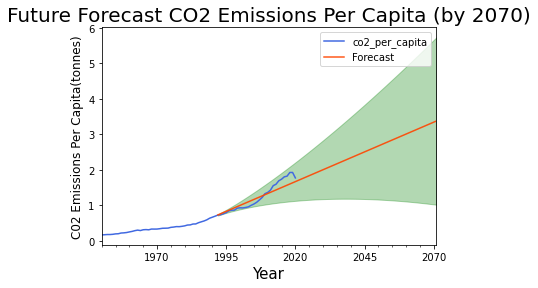

In [73]:
#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
forecast2070.predicted_mean.plot(ax=ax, label='Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(forecast2070_ci.index,
               forecast2070_ci.iloc[:, 0],
               forecast2070_ci.iloc[:, 1],
               color='g', alpha=0.3)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita(tonnes)', size=12)
ax.set_title('Future Forecast CO2 Emissions Per Capita (by 2070)', size=20)

plt.legend()
plt.show()

### SARIMA Model

In [74]:
#building the model
from pmdarima.arima import auto_arima
smodel = auto_arima(df_India, 
                   trace=True, 
                   error_action='ignore', 
                   suppress_warnings=True, 
                   seasonal=True, 
                   m=6, 
                   stepwise=True)
smodel_fit = smodel.fit(df_India)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[6]             : AIC=-545.019, Time=0.51 sec
 ARIMA(0,2,0)(0,0,0)[6]             : AIC=-512.130, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[6]             : AIC=-521.724, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[6]             : AIC=-530.338, Time=0.07 sec
 ARIMA(2,2,2)(0,0,1)[6]             : AIC=-540.589, Time=0.29 sec
 ARIMA(2,2,2)(1,0,0)[6]             : AIC=-542.924, Time=0.27 sec
 ARIMA(2,2,2)(2,0,1)[6]             : AIC=-540.066, Time=0.93 sec
 ARIMA(2,2,2)(1,0,2)[6]             : AIC=-543.191, Time=1.14 sec
 ARIMA(2,2,2)(0,0,0)[6]             : AIC=-543.778, Time=0.23 sec
 ARIMA(2,2,2)(0,0,2)[6]             : AIC=-546.205, Time=1.05 sec
 ARIMA(1,2,2)(0,0,2)[6]             : AIC=-532.015, Time=0.97 sec
 ARIMA(2,2,1)(0,0,2)[6]             : AIC=-541.145, Time=0.82 sec
 ARIMA(3,2,2)(0,0,2)[6]             : AIC=-540.110, Time=0.73 sec
 ARIMA(2,2,3)(0,0,2)[6]             : AIC=-532.745, Time=0.84 sec
 ARIMA(1,2,1)(0,0,2)[6]          

In [75]:
# Train-test split
xs = df_India.index
ys = df_India['co2_per_capita']

strain = df_India.loc[:'1991-01-01']
stest = df_India.loc['1991-01-01':]

x_strain, x_stest = strain.index, stest.index
y_strain, y_stest = strain['co2_per_capita'], stest['co2_per_capita']

In [76]:
#instatiate SARIMA Model
smodel = ARIMA(y_strain[2:],order=(2,2,2),seasonal_order=(0,0,2,6))
smodel_fit = smodel.fit()

#Prediction
pred_mods = smodel_fit.predict(start='1990-01-01', end='2020-01-01', dynamic=False)

In [78]:
print('RMSE for SARIMA model on original data:', RMSE_reg(pred_mods, y_strain))
print('MAE for SARIMA model on original data:', MAE(pred_mods))
print('MAPE for SARIMA model on original data:', MAPE(pred_mods))
print('AIC for SARIMA model on original data:', AIC(smodel_fit))

RMSE for SARIMA model on original data: 0.004803363060488649
MAE for SARIMA model on original data: 0.09547729256343984
MAPE for SARIMA model on original data: 8.190497294699059
AIC for SARIMA model on original data: -564.289253071205


From above we can observe,
- SARIMA model has lower MAE, RMSE, MAPE than best ARIMA(0,2,2)

**Analyse Model**

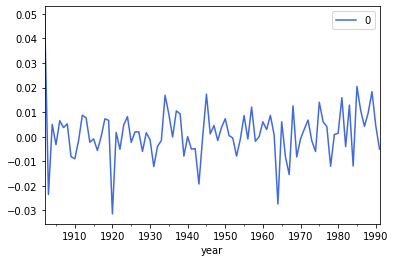

In [79]:
#Visualize resicudals
residuals = DataFrame(smodel_fit.resid)
residuals.plot(color='royalblue')
plt.show()

In [80]:
#observe residuals/error distributions
residuals.describe()

,0
count,90.000000
mean,0.001347
std,0.010551
min,-0.031412
25%,-0.003707
50%,0.001026
75%,0.006738
max,0.049000


Based on the above, we observe that our model has minimal error with little bias, with a mean of approximately 0. Next, we observe a density plot of the residual error values, suggesting the errors ar gaussian, but may not be centered on zero

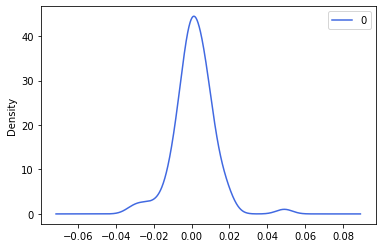

In [81]:
#check for linearlity
residuals = DataFrame(smodel_fit.resid)
residuals.plot(kind='kde', color='royalblue')
plt.show()

Based on the above, we observe that our model is nearly linear, with mean of approximately 0. Next we observe the diagnostics to evaluate our model

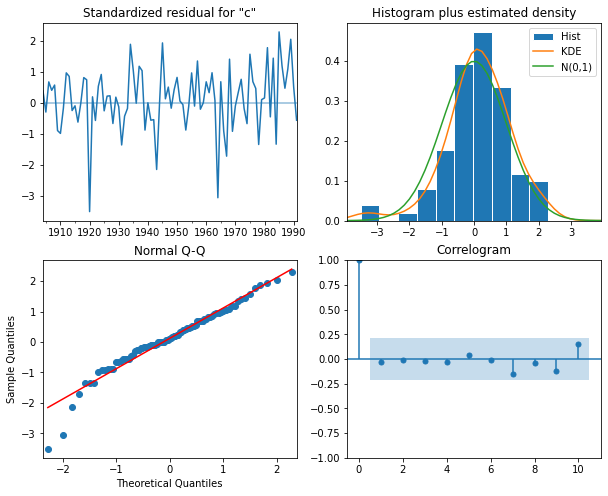

In [82]:
#observe diagonstics
smodel_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In the top right plot, thw orangered line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation 1. This is a good indication thath the residuals are normally distributed. The forecast errors deviate a little bit from the straight line, indicating that the normal distribution is not a perfect model for the distribution of forecast errors, but it is not unreasonable.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again,this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e, correlation) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [83]:
#observe predictions
pred_smodel = smodel_fit.get_prediction(start='1990-01-01', end='2020-01-01', dynamic=False)
pred_sci = pred_smodel.conf_int()
pred_sci.sample(10)

,lower co2_per_capita,upper co2_per_capita
2008-01-01,1.065966,1.610891
2013-01-01,1.132415,1.934902
2018-01-01,1.181917,2.275846
2006-01-01,1.033989,1.486766
2003-01-01,0.979187,1.306297
2004-01-01,0.998235,1.365980
1990-01-01,0.639912,0.674988
2011-01-01,1.108017,1.803121
1995-01-01,0.796069,0.880682
2000-01-01,0.914355,1.136463


we observe the real and forecasted values of the co2 emissions time series to assess how well the model fits.

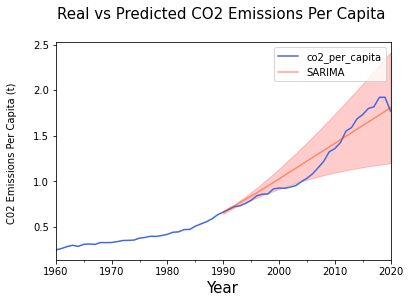

In [84]:
#observe real vs forecasted emissions values

#plot observed values
ax = df_India['1960-01-01':].plot(label='observed', color='royalblue', legend=True)

#plot predicted values
pred_smodel.predicted_mean.plot(ax=ax, label='SARIMA', color='orangered', alpha=0.5, legend=True)

#add fill between lines, set axes labels and title
ax.fill_between(pred_sci.index,
               pred_sci.iloc[:, 0],
               pred_sci.iloc[:, 1],
               color='r', alpha=0.2)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita (t) \n', size=10)
ax.set_title('Real vs Predicted CO2 Emissions Per Capita \n', size=15)

plt.legend(loc='best')
plt.show()


In [96]:
#get dynamic predictions
pred_sdynamic = smodel_fit.get_prediction(start='1990-01-01', end='2020-01-01', dynamic=True, full_results=True)
#get confidence Intervals
pred_sdynamic_ci = pred_sdynamic.conf_int()
pred_sdynamic_ci.head(10)

,lower co2_per_capita,upper co2_per_capita
1990-01-01,0.639912,0.674988
1991-01-01,0.666509,0.716381
1992-01-01,0.695312,0.760186
1993-01-01,0.722572,0.807186
1994-01-01,0.745438,0.853024
1995-01-01,0.771679,0.904136
1996-01-01,0.791273,0.952083
1997-01-01,0.815826,1.006444
1998-01-01,0.838277,1.060385
1999-01-01,0.858872,1.114328


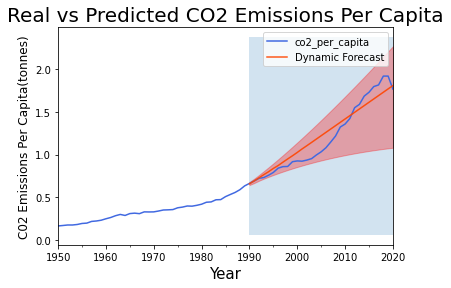

In [95]:
#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
pred_sdynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:, 0],
               pred_dynamic_ci.iloc[:, 1],
               color='r', alpha=0.3)

ax.fill_betweenx(ax.get_ylim(),
                '1990-01-01',
                df_India.index[-1],
                alpha=0.2,
                zorder= -1)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita(tonnes)', size=12)
ax.set_title('Real vs Predicted CO2 Emissions Per Capita', size=20)

plt.legend()
plt.show()

### Forecast Future CO2 emissions (SARIMA)

In [87]:
#get forecast of 10 years stpes ahead in future
forecast2030_s= smodel_fit.get_forecast(steps=40)
#get confidence Intervals
forecast2030_sci = forecast2030_s.conf_int()
forecast2030_sci.sample(10)

,lower co2_per_capita,upper co2_per_capita
2018-01-01,1.181917,2.275846
2030-01-01,1.242360,3.152475
2002-01-01,0.959578,1.250084
2004-01-01,0.998235,1.365980
2019-01-01,1.189976,2.345877
2031-01-01,1.244053,3.228872
2017-01-01,1.173264,2.206410
1995-01-01,0.796069,0.880682
2009-01-01,1.080747,1.674217
2003-01-01,0.979187,1.306297


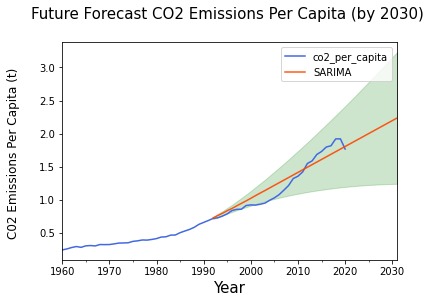

In [88]:
#plot observed values
ax = df_India['1960-01-01':].plot(label='observed', color='royalblue', legend=True)

#plot predicted values
forecast2030_s.predicted_mean.plot(ax=ax, label='SARIMA', color='orangered', alpha=0.9, legend=True)

#add fill between lines, set axes labels and title
ax.fill_between(forecast2030_sci.index,
               forecast2030_sci.iloc[:, 0],
               forecast2030_sci.iloc[:, 1],
               color='g', alpha=0.2)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita (t) \n', size=12)
ax.set_title('Future Forecast CO2 Emissions Per Capita (by 2030) \n', size=15)

plt.legend()
plt.show()

**Comparison**



Lets compare and observe the predictions of ARIMA, SARIMA and Holt-Winter's models

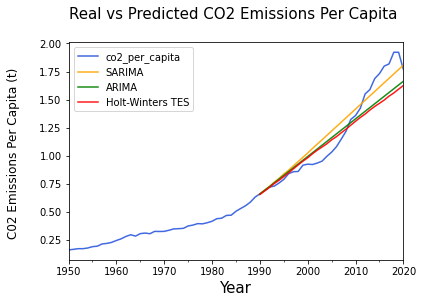

In [89]:
#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue', legend=True)

#plot predicted values
#SARIMA Model
pred_smodel.predicted_mean.plot(ax=ax, label='SARIMA', color='orange', alpha=0.9, legend=True)
#ARIMA Model
pred_model222.predicted_mean.plot(ax=ax, label='ARIMA', color='green', alpha=0.9, legend=True)
#Holt-Winter's TES
test_tes_pred = model_tes_fit.predict(start='1990-01-01', end='2020-01-01')
test_tes_pred.plot(ax=ax, label='Holt-Winters TES', color='red', alpha=0.9, legend = True)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita (t) \n', size=12)
ax.set_title('Real vs Predicted CO2 Emissions Per Capita \n', size=15)

plt.legend()
plt.show()

Lets compare and observe the forecasts of ARIMA, SARIMA and Holt-Winter's models

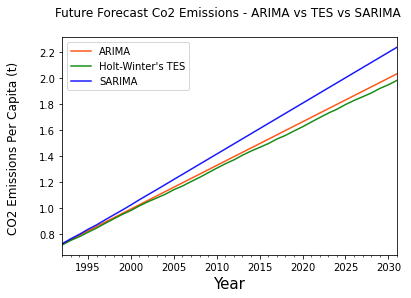

In [90]:
#plot Forecast values of ARIMA
ax = forecast2030.predicted_mean.plot( label='ARIMA', color='orangered', alpha=0.9, legend = True)

#plot Forecast values of Holt-Winter's
test_tes_40.plot(ax=ax, label = "Holt-Winter's TES", color='green', alpha=0.9,legend = True)
forecast2030_s.predicted_mean.plot(ax=ax, label='SARIMA', color='blue', alpha=0.9)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('CO2 Emissions Per Capita (t) \n', size=12)
ax.set_title('Future Forecast Co2 Emissions - ARIMA vs TES vs SARIMA \n', size=12)

plt.legend()
plt.show()

In [91]:
#evaluate RMSE for ARIMA, SARIMA and Holt-Winter's Model
print("RMSE for the ARIMA Model : ", RMSE_reg(pred222, y_stest))
print("RMSE for the SARIMA Model : ", RMSE_reg(pred_mods, y_stest))
print("RMSE for the TES Model : ", np.sqrt(tes_mse))

RMSE for the ARIMA Model :  0.1434490184382893
RMSE for the SARIMA Model :  0.11520431004307816
RMSE for the TES Model :  0.14843679228340276


From above we observe, SARIMA model provides better results than ARIMA/Holt-Winter's TES model

## Extending the model LSTM to improve the results

**Hybrid Model - SARIMA + LSTM**

In [112]:
emissions_forecast = pd.DataFrame(pred_sdynamic.predicted_mean)
emissions_original = df_India['1990-01-01':]

emissions_forecast.rename(columns={'predicted_mean': 'co2_per_capita'}, inplace = True)
emissions_forecast

,co2_per_capita
1990-01-01,0.657450
1991-01-01,0.691445
1992-01-01,0.727749
1993-01-01,0.764879
1994-01-01,0.799231
1995-01-01,0.837908
1996-01-01,0.871678
1997-01-01,0.911135
1998-01-01,0.949331
1999-01-01,0.986600


In [135]:
df_lstm = df_India[:'1990-01-01']
frames= [df_lstm,emissions_forecast]
df_lstm = pd.concat(frames)

In [136]:
df_lstm.tail(10)

,co2_per_capita
2011-01-01,1.457668
2012-01-01,1.496908
2013-01-01,1.536147
2014-01-01,1.575387
2015-01-01,1.614626
2016-01-01,1.653866
2017-01-01,1.693105
2018-01-01,1.732344
2019-01-01,1.771584
2020-01-01,1.810823


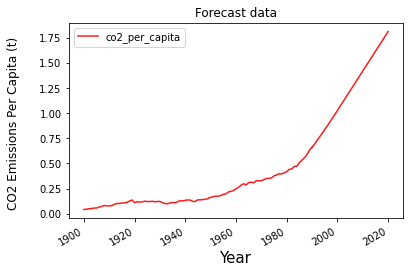

In [137]:
ax = df_lstm.plot( label='forecast co2 emissions', color='red', alpha=0.9, legend = True)
ax.set_xlabel('Year', size=15)
ax.set_ylabel('CO2 Emissions Per Capita (t) \n', size=12)
ax.set_title('Forecast data', size=12)

plt.legend()
plt.show()

### Model

**Reporducibility** is extremely important as the parameter makes sure that when code is re-run, produces similar results

In [138]:
#fix random seed for reproducibility
np.random.seed(42)

In [139]:
data = df_lstm['co2_per_capita']
dataset = df_lstm.values
dataset = dataset.astype('float32')

In [140]:
df_lstm.tail(10)

,co2_per_capita
2011-01-01,1.457668
2012-01-01,1.496908
2013-01-01,1.536147
2014-01-01,1.575387
2015-01-01,1.614626
2016-01-01,1.653866
2017-01-01,1.693105
2018-01-01,1.732344
2019-01-01,1.771584
2020-01-01,1.810823


**Normalize Input**

As with other deep learning problems, we can help neural network learn more rapidly by normalizing the inputs between 0 and 1. We will use `MinMaxScaler` for normalizing the input

In [141]:
#normalize
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(dataset) #try standard scaler

***Tasks***

> - _Adressing Trends and Stationarity - log transform and Differncing-
> - _Modelling_           (completed & yet to be reviewed | Add Explanation)
    - _ACF and PACF_
    - _AR, MA_
    - _ARIMA_
    - _SARIMA_
> - _Performance_
    - _RMSE_
    - _AIC_
    - _MAE_
    - _MAPE_
> - _Analyse Final Model_
> - _Forecast Target Years_

> - _Check Possibility of Building Holt's, Holt-winter's Model (Exponential Smoothing)_
    - _Performance_
    - _Analyse Final Model_
    - _Forecast Target Years_

> - Build Neural Networks (ongoing)
    - GRU
    - LSTM (ongoing)
> - Performance and Analyse Neural Networks


